![My Title](coverpage.png)

# First DataSet: MovieLens
(https://grouplens.org/datasets/movielens)

## Problem Statement

Nowadays, we need recommender systems almost everywhere in our lives. Therefore, retailers are become more interested in recommender systems to analyze patterns of user interest in products and provide personalized recommendations. The first goal of this project is understanding, analyzing, and correlating the trend in average rating movies of different genres from 1995-2015. The second goal is building a recommender engine to predict the rating of each movie. 

## Business Objective

The recommender system is useful to any business that makes money via recommendations. Since we want to work with movie dataset, the client of this project could be Amazon, Netflix, Hulu, HBO, etc. 
Giving good recommendations will help users spend less time searching for their type of movie and having a recommender platform. This will help the customer to continue with the service and having a good experience.

## Data

I use two datasets for this project as:

1-The first dataset is collected from a free, noncommercial movie recommender as  MoviLens.org. (https://grouplens.org/datasets/movielens).
 This recommender is like Netflix, minus the ability to watch movies. The dataset which was released in April 2015 contains 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users (movies.csv, ratings.csv, link.csv). The data has been created in October 2016. Users were selected at random for inclusion. All selected users had rated at least 20 movies.
 
2- The second dataset is collected from (https://www.kaggle.com/karrrimba/movie-metadatacsv). We have more features in this dataset like information about revenue, budget, release date, popularity,... .

## Solution

__1- How to get the insight about how people’s rating change for different genres over the years?__

Getting different distributions of the movie-ratings and movie-relevancy across title, genre, year, and tag of each movie can give the insight about how people’s taste vary over the years. Different inferential statistics and visualization techniques can be implemented to deliver a better understanding of the trends.

__2- How to recommend movies?__

In this work different Collaborative filtering (CF)  and Content-based filtering techniques will be used to analyze relationships between users and interdependencies among products to identify new user-item associations. Most CF algorithms are based on a user-item rating matrix where each row represents a user, each column an item. The entries of this matrix are ratings given by users to items. One of the primary areas of collaborative filtering is the latent factor models which are based on matrix factorization (Singular value decomposition (SVD)).

__3- How to predict movie ratings?__

In this work different machine learning techniques like Random Forest, Support Vector Machine, K-Nearest Neighbors,... will be implemented to predict the rating of the test set.


## Workflow

- Collecting data and applying data wrangling methods
- Starting exploratory data analysis to find trends and storytelling
- Conduct further data analysis to identify relationships between different variables
- Perform in-depth analysis using collaborative filtering and machine learning techniques to recommend and  predict


## Import libraries, Read the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate, SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
from __future__ import (absolute_import, division, print_function,unicode_literals)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit
import tensorrec

C:\Python\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Reading the data

In [2]:
r=pd.read_csv('ratings.csv')
r.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
movies=pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.4+ KB


# Data Wrangling

In [5]:
movies['genres'] = movies['genres'].str.split('|')
movies['year']=movies['title'].str[-5:-1]
movies=movies[(movies['title'].str[-1]==')')&(movies['title'].str[-6]=='(')] #drop the movies without year in title
movies.year=pd.to_numeric(movies.year)
movies['Decade']=movies['year']//10 *10
movies=movies.set_index('movieId')
movies.sort_values('year').head() 

,title,genres,year,Decade
movieId,,,,
129851,Dickson Greeting (1891),[(no genres listed)],1891,1890
95541,Blacksmith Scene (1893),[(no genres listed)],1893,1890
94951,Dickson Experimental Sound Film (1894),[Musical],1894,1890
88674,Edison Kinetoscopic Record of a Sneeze (1894),[Documentary],1894,1890
120869,Employees Leaving the Lumière Factory (1895),[Documentary],1895,1890


** Seperating each Genre**

In [6]:
sep = movies.reset_index().set_index(['movieId','title','year'])['genres'].apply(pd.Series).stack()
sep = sep.reset_index()
sep.columns=['movieId','title','year','level','genres']
sep.to_csv('sep.csv')
print('Available Genres: ',sep.genres.unique())
sep.head()

Available Genres:  ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


,movieId,title,year,level,genres
0,1,Toy Story (1995),1995,0,Adventure
1,1,Toy Story (1995),1995,1,Animation
2,1,Toy Story (1995),1995,2,Children
3,1,Toy Story (1995),1995,3,Comedy
4,1,Toy Story (1995),1995,4,Fantasy


# Exploratory Data Analysis (Storytelling)

In [7]:
df = pd.merge(r,movies,on='movieId')
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"""Great Performances"" Cats (1998)",2.748387,155
#chicagoGirl: The Social Network Takes on a Dictator (2013),3.666667,3
$ (Dollars) (1971),2.833333,24
$5 a Day (2008),2.871795,39
$9.99 (2008),3.009091,55


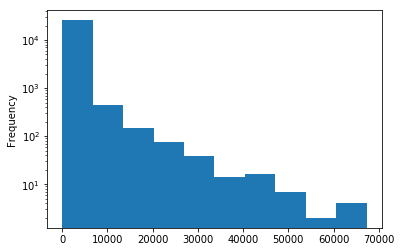

In [8]:
ratings['num of ratings'].plot(logy=True, kind='hist')
plt.show()

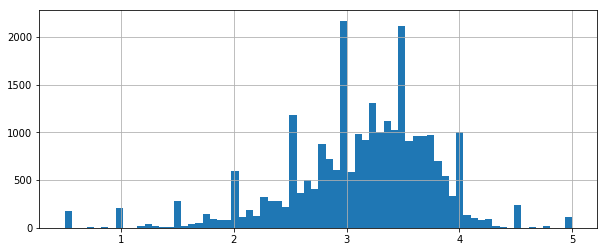

In [9]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.show()

C:\Python\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Python\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


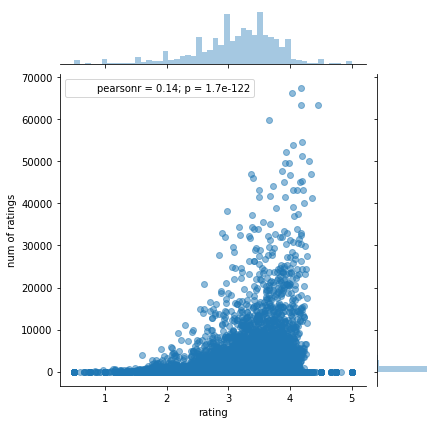

In [10]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.show()

Total number of movies of each Genre

**Drama, Comedy, and Thriller** have the most production.


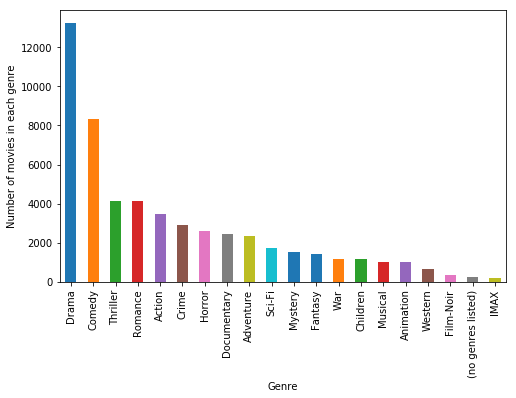

In [11]:
plt.figure(figsize=(8,5))
sep['genres'].value_counts().plot(kind='bar')
plt.ylabel('Number of movies in each genre')
plt.xlabel('Genre')
plt.savefig('foo.png',dpi=300,bbox_inches='tight')
plt.show()


Total number of movies in each decade

Most production was in **2000 decade.**

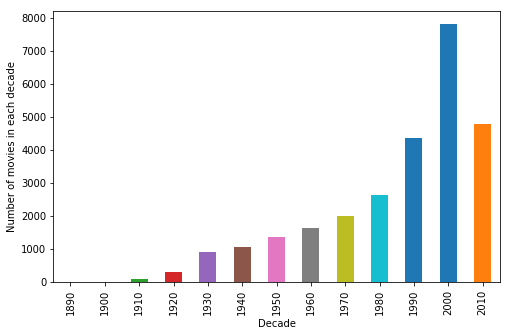

In [12]:
plt.figure(figsize=(8,5))
movies['Decade'].value_counts().sort_index().plot(kind='bar') 
plt.xlabel('Decade')
plt.ylabel('Number of movies in each decade')
plt.savefig('foo1.png',dpi=300,bbox_inches='tight')
plt.show()

3 years with most Drama genre are:

Most drama movies produced in **2009, 2007, and 2008** respectively.

In [13]:
sep[sep['genres']=='Drama']['year'].value_counts().head(3) 

2009    505
2007    473
2008    462
Name: year, dtype: int64

Number of drama movies in each decade.

Most drama movies produced in **decade 2000 **.

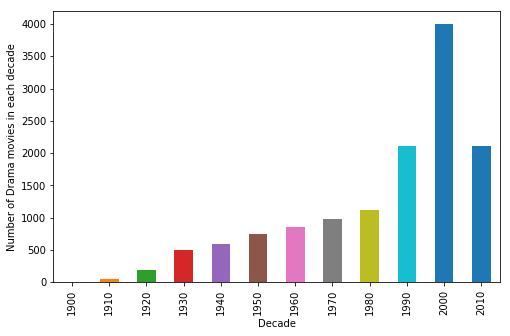

In [14]:
plt.figure(figsize=(8,5))
sep['Decade']=sep['year']//10 *10
sep[sep['genres']=='Drama']['Decade'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Decade')
plt.ylabel('Number of Drama movies in each decade')
plt.savefig('foo2.png',dpi=300,bbox_inches='tight')
plt.show()

Movies with same title including the year are:

*16 movies* are with same title.

In [15]:
sum(movies['title'].value_counts()>1)

16

These movies which have repeated twice including the year are:

In [16]:
movies['title'].value_counts().head(16) 

Hamlet (2000)                          2
Johnny Express (2014)                  2
Emma (1996)                            2
Clear History (2013)                   2
Darling (2007)                         2
Girl, The (2012)                       2
Men with Guns (1997)                   2
Beneath (2013)                         2
Chaos (2005)                           2
Aladdin (1992)                         2
Casanova (2005)                        2
Paradise (2013)                        2
Offside (2006)                         2
War of the Worlds (2005)               2
20,000 Leagues Under the Sea (1997)    2
Blackout (2007)                        2
Name: title, dtype: int64

These movie titles (excluding the year in the title) have been repeated several times.

In [17]:
movies['Name']=movies['title'].str[:-7] #removing the year from title
movies['Name'].value_counts().head(20) 

Misérables, Les              9
Hamlet                       8
Three Musketeers, The        7
Alice in Wonderland          6
Christmas Carol, A           6
Wuthering Heights            6
Jane Eyre                    5
Cinderella                   5
Eden                         4
Boy Meets Girl               4
Emma                         4
Angel                        4
Dangerous Liaisons           4
The Count of Monte Cristo    4
Oliver Twist                 4
Raven, The                   4
Carrie                       4
Dr. Jekyll and Mr. Hyde      4
Maniac                       4
Blackout                     4
Name: Name, dtype: int64

8 movies have been produced with the title 'Hamlet', The following barplot shows the number of 'Hamlet' movies in each decade.

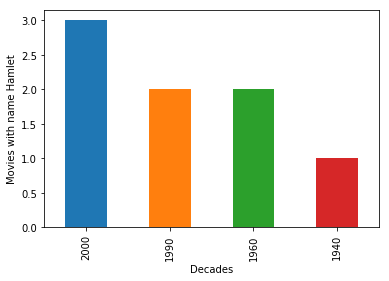

In [18]:
movies[movies.Name=='Hamlet'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Hamlet')
plt.savefig('foo2.png',dpi=300,bbox_inches='tight')
plt.show()


9 movies has been produced with title 'Misérables, Les'. The following barplot shows the number of 'Misérables, Les' movies in each decade. 

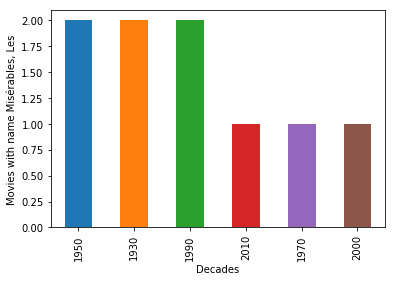

In [19]:
movies[movies.Name=='Misérables, Les'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Misérables, Les')
plt.savefig('foo3.png',dpi=300,bbox_inches='tight')
plt.show()

In [20]:
r.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

Movies with highest rankings are:

**Rank=5**
- As it was expected, **Shawshank Redemption, Pulp Fiction and Silence of the Lambs** are the first three.

**Rank=4.5**
- The first three are, **Shawshank Redemption, Matrix, and Pulp Fiction.**

**Rank=4**
- The first three are, **Silence of the Lambs, Fugitive, and Jurassic.**


In [21]:
List=[]
for i in np.arange(4,5.5, 0.5):
    M=movies.loc[r[r.rating==i].movieId.value_counts().head(10).index,'title']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
593             Silence of the Lambs, The (1991)
457                         Fugitive, The (1993)
356                          Forrest Gump (1994)
480                         Jurassic Park (1993)
589            Terminator 2: Judgment Day (1991)
150                             Apollo 13 (1995)
1                               Toy Story (1995)
296                          Pulp Fiction (1994)
32     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
110                            Braveheart (1995)
Name: title, dtype: object
 
Rate: 4.500000
318                      Shawshank Redemption, The (1994)
2571                                   Matrix, The (1999)
296                                   Pulp Fiction (1994)
2959                                    Fight Club (1999)
4993    Lord of the Rings: The Fellowship of the Ring,...
5952        Lord of the Rings: The Two Towers, The (2002)
7153    Lord of the Rings: The Return of the King, The...
50                             Usual Suspects

Average rating for the **Shawshank Redemption** is:

In [22]:
r[r.movieId==318].rating.mean()  #Average rating for the 'Shawshank Redemption, The'

4.446990499637029

Average rating for the **Pulp Fiction** is:

In [23]:
r[r.movieId==296].rating.mean() #Average rating for 'Pulp Fiction' 

4.174231169217055

The movies with the max number of ratings are:

**Pulp Fiction, Forrest Gump, Shawshank redemption** respectively.

In [24]:
MaxRating=r['movieId'].value_counts().head(10)

In [25]:
movies.loc[MaxRating.index,'title'] 

296                           Pulp Fiction (1994)
356                           Forrest Gump (1994)
318              Shawshank Redemption, The (1994)
593              Silence of the Lambs, The (1991)
480                          Jurassic Park (1993)
260     Star Wars: Episode IV - A New Hope (1977)
110                             Braveheart (1995)
589             Terminator 2: Judgment Day (1991)
2571                           Matrix, The (1999)
527                       Schindler's List (1993)
Name: title, dtype: object

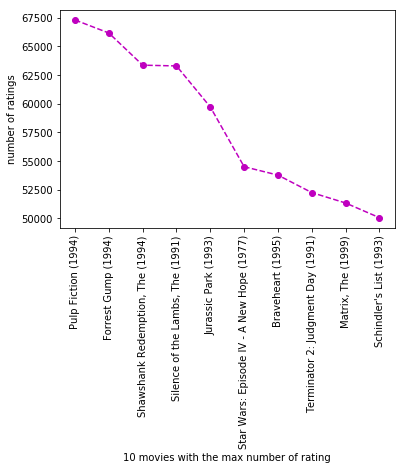

In [26]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('10 movies with the max number of rating')
plt.ylabel('number of ratings')
plt.savefig('foo4.png',dpi=300,bbox_inches='tight')
plt.show()

The movies with the highest average rating are:

**Pulp Fiction, Forrest Gump, Shawshank redemption** respectively

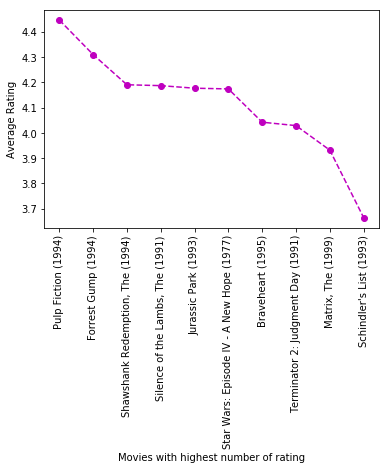

In [27]:
List5=[]
for i in MaxRating.index:
    List5.append(r[r.movieId==i].rating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('Movies with highest number of rating')
plt.ylabel('Average Rating')
plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

In [28]:
MinRating=r['movieId'].value_counts()
MinRating=MinRating[MinRating==1]
print('Number of movies which are rated once:',movies.loc[MinRating.index,'title'].shape) 

C:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Number of movies which are rated once: (3972,)


Merge movie and rating data frames.

In [29]:
r1= r.merge(sep.reset_index(), left_on='movieId', right_on='movieId', how='inner')
del r1['timestamp']
r1.head() #merge sep and rating

,userId,movieId,rating,index,title,year,level,genres,Decade
0,1,2,3.5,5,Jumanji (1995),1995,0,Adventure,1990
1,1,2,3.5,6,Jumanji (1995),1995,1,Children,1990
2,1,2,3.5,7,Jumanji (1995),1995,2,Fantasy,1990
3,5,2,3.0,5,Jumanji (1995),1995,0,Adventure,1990
4,5,2,3.0,6,Jumanji (1995),1995,1,Children,1990


Boxplot of 'Decade' vs 'Rating'

*Movies of **40th decade** has the highest rating*

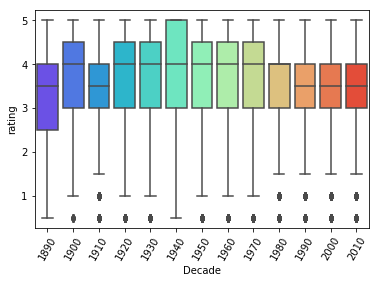

In [30]:
sns.boxplot(x='Decade', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=60)
plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

Boxplot of the 'Decade' vs 'Genres'

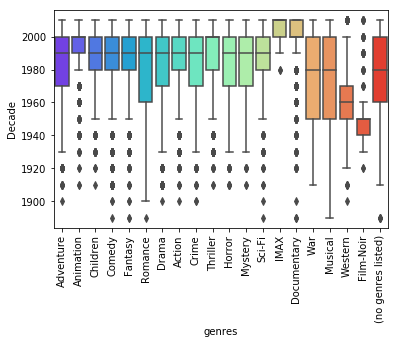

In [31]:
sns.boxplot(x='genres', y='Decade', data=sep,palette='rainbow')
plt.xticks(rotation=90)
plt.savefig('foo6.png',dpi=300,bbox_inches='tight')
plt.show()

Average rating of the ppl with highest number of rating

In [32]:
ID=r1.userId.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(r1[r1.userId==i]['rating'].mean())

List5

[3.2909304463282605,
 3.2126359112967626,
 1.654984847307483,
 3.026239975083703,
 2.780034504391468,
 3.765411234508289,
 3.4983650780675224,
 3.225420576549159,
 2.4983633387888706,
 3.3196820944366525]

Boxplot of the 'Genre' vs 'Rating' 

**Drama, Mystery,Crime, War,Imax, documentary** has the highest ratings. **Horror** is the least favorit.

<function matplotlib.pyplot.show(*args, **kw)>

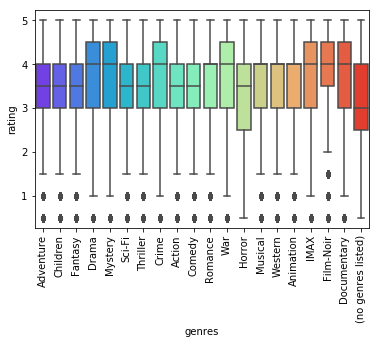

In [33]:
sns.boxplot(x='genres', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=90)
plt.savefig('foo7.png',dpi=300,bbox_inches='tight')
plt.show

Correlation matrix: (There is no correlation)

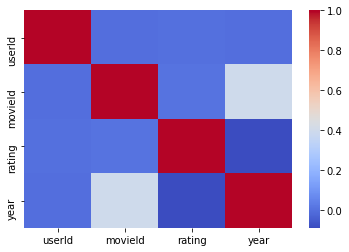

In [34]:
sns.heatmap(r1[['userId','movieId','rating','year']].corr(),cmap='coolwarm')
plt.show()

 ## Title Wordclouds
There are certain words that use more often in titles. I use WordCloud library to find out what are these words.

The word **Love** is the most commonly used word in movie titles. **Girl**, **Day** and **Man** are also among the most commonly occuring words. 

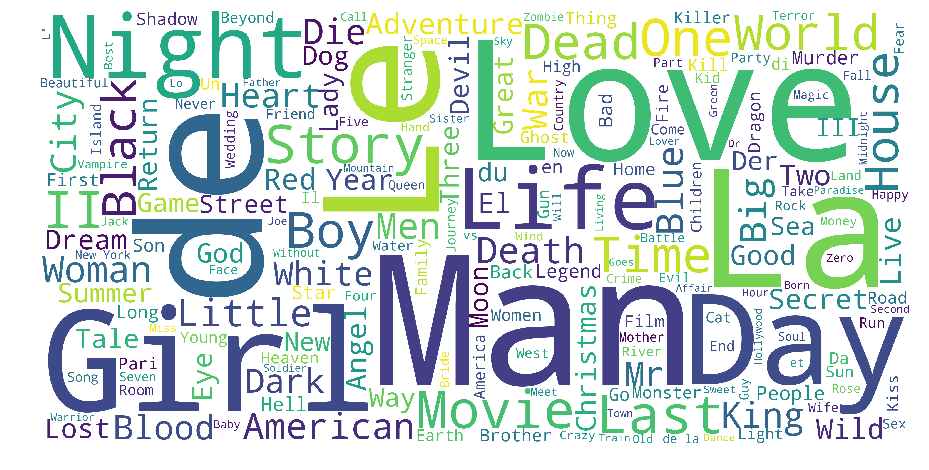

In [35]:
movies['title'] = movies['title'].astype('str')

title_corpus = ' '.join(movies['title'])


title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.savefig('world1.png',dpi=300,bbox_inches='tight')
plt.show()

# Recommender System


### Preparing the data

In [36]:
movielens=r.drop(['timestamp'],axis=1)
movielens=movielens.iloc[(r.userId.value_counts()>100).index,:]#user id with more than 100 voting

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(movielens[['userId','movieId']],movielens['rating'],test_size=0.25, 
                                                  random_state=55)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

## Well-known Solutions to the Recommendation Problem are:


## 1- Simple Recommender
The Simple Recommender offers generalized recommnendations to every user based on movie popularity, ratings, and genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

So I sort the movies base on their genre, and I recommend the ones with the highest number of votes and the higher average rankings to the new audience.

In [38]:
r1=r1[['userId','movieId','rating','title','genres']]
r1.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure
1,1,2,3.5,Jumanji (1995),Children
2,1,2,3.5,Jumanji (1995),Fantasy
3,5,2,3.0,Jumanji (1995),Adventure
4,5,2,3.0,Jumanji (1995),Children


### The list of the 10 best Drama movies to recommend are:


In [39]:
a=r1[r1.genres=='Drama'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Drama')&(r1.movieId==i)].title.iloc[0])

1 : Pulp Fiction (1994)
2 : Shawshank Redemption, The (1994)
3 : Schindler's List (1993)
4 : American Beauty (1999)
5 : Fargo (1996)
6 : Godfather, The (1972)
7 : Fight Club (1999)
8 : Lord of the Rings: The Return of the King, The (2003)
9 : One Flew Over the Cuckoo's Nest (1975)
10 : Godfather: Part II, The (1974)


### The list of the 10 best Romance movies to recommend are:


In [40]:
a=r1[r1.genres=='Romance'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>3.5)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Romance')&(r1.movieId==i)].title.iloc[0])

1 : Forrest Gump (1994)
2 : Beauty and the Beast (1991)
3 : Princess Bride, The (1987)
4 : Groundhog Day (1993)
5 : Shrek (2001)
6 : Sleepless in Seattle (1993)
7 : Good Will Hunting (1997)
8 : Four Weddings and a Funeral (1994)
9 : Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
10 : There's Something About Mary (1998)


### The list of the 10 best Action movies to recommend are:



In [41]:
a=r1[r1.genres=='Action'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Action')&(r1.movieId==i)].title.iloc[0])

1 : Star Wars: Episode IV - A New Hope (1977)
2 : Braveheart (1995)
3 : Matrix, The (1999)
4 : Star Wars: Episode VI - Return of the Jedi (1983)
5 : Star Wars: Episode V - The Empire Strikes Back (1980)
6 : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
7 : Fight Club (1999)
8 : Saving Private Ryan (1998)
9 : Princess Bride, The (1987)
10 : Lord of the Rings: The Return of the King, The (2003)


## 2- IMDB Weighted Rating Formula
Another technique could be IMDB's *weighted rating* formula which is mathematically represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [42]:
C=r1.groupby('movieId').rating.mean().mean()
m=r1.movieId.value_counts().quantile(0.95)
print(' mean vote across the whole report (C):',C)
print('minimum votes required to be listed in the chart (m):',m)

 mean vote across the whole report (C): 3.1336633211120817
minimum votes required to be listed in the chart (m): 8463.75


In [43]:
a=r1.movieId.value_counts().sort_index()
b=r1.groupby('movieId').rating.mean()

In [44]:
print('Number of Movies which are qualified:',sum((a>m)&(b>C)))

Number of Movies which are qualified: 1061


In [45]:
a=pd.DataFrame(a.values,columns=['counts'],index=a.index)
b=pd.DataFrame(b.values,columns=['mean'],index=b.index)

In [46]:
df=pd.concat([a,b], axis=1, sort=False)
qualified = df[(df['counts'] >= m)  & (df['mean']>=C)]

print(qualified.shape[0],' movies are qualified')

1061  movies are qualified


In [47]:
def weighted_rating(x):
    v = x['counts']
    R = x['mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False)

List1=[]
for i in qualified.head(30).index:
    List1.append(movies[movies.index==i]['title'].values)
IMDBBest=pd.DataFrame(List1,columns=['Best to Recommend'])
IMDBBest

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Best to Recommend
0,"Shawshank Redemption, The (1994)"
1,"Usual Suspects, The (1995)"
2,"Godfather, The (1972)"
3,Schindler's List (1993)
4,Fight Club (1999)
5,Pulp Fiction (1994)
6,Star Wars: Episode IV - A New Hope (1977)
7,"Silence of the Lambs, The (1991)"
8,"Matrix, The (1999)"
9,Star Wars: Episode V - The Empire Strikes Back...


## 2- Content-based filtering



The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 10 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

Content based filtering *Recommend based on the user's rating history.* 

Generic expression (notice how this is kind of a 'row-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{i' \in I(u)} [r_{u,i'}]
$$


A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_u = \frac{\sum_{i' \in I(u)} r_{u,i'}}{|I(u)|} 
$$


In [48]:
def evaluate(estimate_f):
    ids_to_estimate = zip(test.userId, test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = y_test.values
    return np.sqrt(np.mean(np.power(estimated-real, 2)))

def content_mean(user_id, movie_id):
    user_condition = X_train.userId == user_id
    return y_train[user_condition].mean()

start = time.time()
print('RMSE for content base filtering is: %s' % round(evaluate(content_mean),4))
end = time.time()
print('Total elapsed time of content base filtering is:',round(end - start,3))


RMSE for content base filtering is: 0.9969
Total elapsed time of content base filtering is: 65.319



## 3- Collaborative Filtering

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.


#### I- Simple Collaborative filtering base on mean

*Recommend based on other user's rating histories.* 

Generic expression (notice how this is kind of a 'col-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{u' \in U(i)} [r_{u',i}] 
$$
A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_i = \frac{\sum_{u' \in U(i)} r_{u',i}}{|U(i)|} 
$$


In [49]:
def collab_mean(user_id, movie_id):
    user_condition = X_train.movieId == movie_id
    return y_train[user_condition].mean()

i=1
j=151
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')

i=1
j=29
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')



i=138493
j=55269
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')

Collaborative mean filter for userId: 1 and movieId: 151 is: [3.31060606]
Actual rating value is: 4.0

Collaborative mean filter for userId: 1 and movieId: 29 is: [3.80232558]
Actual rating value is: 3.5

Collaborative mean filter for userId: 138493 and movieId: 55269 is: [4.06666667]
Actual rating value is: 5.0



#### II- Matrix Factorization-based algorithms

The idea is basically to take a large (or potentially huge) matrix and factor it into some smaller representation of the original matrix. You can think of it in the same way as we would take a large number and factor it into two much smaller primes. We end up with two or more lower dimensional matrices whose product equals the original one.
When we talk about collaborative filtering for recommender systems we want to solve the problem of our original matrix having millions of different dimensions, but our “tastes” not being nearly as complex. Even if i’ve viewed hundreds of items they might just express a couple of different tastes. Here we can actually use matrix factorization to mathematically reduce the dimensionality of our original “all users by all items” matrix into something much smaller that represents “all items by some taste dimensions” and “all users by some taste dimensions”. These dimensions are called latent or hidden features and we learn them from our data.
Doing this reduction and working with fewer dimensions makes it both much more computationally efficient and but also gives us better results since we can reason about items in this more compact “taste space”.
If we can express each user as a vector of their taste values, and at the same time express each item as a vector of what tastes they represent. You can see we can quite easily make a recommendation. This also gives us the ability to find connections between users who have no specific items in common but share common tastes.

#### SVD 
SVD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reducing space dimensions from N to K where K < N. For the purpose of the recommendation systems however, we are only interested in the matrix factorization part keeping same dimensionality. The matrix factorization is done on the user-item ratings matrix. From a high level, matrix factorization can be thought of as finding 2 matrices whose product is the original matrix. (https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9)

I use **Surprise** library which has several powerful algorithms like **Singular Value Decomposition (SVD), Non-negative Matrix Factorization (NMF), K Nearest Neighbor (KNN), and CoClusternig**  to minimise RMSE (Root Mean Square Error) and give recommendations.


In [50]:
data = Dataset.load_from_df(movielens[['userId', 'movieId', 'rating']], Reader())

In [51]:
Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]

for i in Models:
    start = time.time()
    cross_validate(i, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    end = time.time()
    print('Total Elapsed time with model is:',end - start)
    print(' ')
    print(' ')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9171  0.9140  0.9113  0.9219  0.9097  0.9148  0.0043  
MAE (testset)     0.7087  0.7049  0.7019  0.7094  0.7012  0.7052  0.0034  
Fit time          13.00   13.68   12.76   43.84   21.19   20.89   11.89   
Test time         0.30    0.39    0.27    1.97    0.73    0.73    0.64    
Total Elapsed time with model is: 110.37742877006531
 
 
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9582  0.9566  0.9623  0.9655  0.9454  0.9576  0.0069  
MAE (testset)     0.7355  0.7348  0.7382  0.7402  0.7297  0.7357  0.0036  
Fit time          26.28   17.84   20.05   17.72   13.88   19.15   4.08    
Test time         0.27    0.51    0.31    0.33    0.34    0.35    0.08    
Total Elapsed time with model is: 99.79825043678284
 
 
Evaluating RMSE, MAE of algor

From the results, **SVD** and **KNN** provide lower RMSE for the test set.


Now lets compare the predicted rating values of some samples with their actual values:

In [52]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25, random_state=55)

Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]
m=['SVD','NMF','Slop One','KNN Baseline', 'CoClustering']

count=0

for algo in Models:
    print(m[count])
    start = time.time()
    algo.fit(trainset)
    predictions = algo.test(testset)
    end = time.time()    
    print('Total Elapsed time with model is:',round(end - start,3)) 
    i=1
    j=151
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    i=1
    j=29
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    i=138493
    j=55269
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    print('')
    count+=1


SVD
Total Elapsed time with model is: 9.202
Prediction of a particular user: 3.69487816192052
Actual rating value is: 4.0

Prediction of a particular user: 3.6717143007180093
Actual rating value is: 3.5

Prediction of a particular user: 3.860117330365739
Actual rating value is: 5.0


NMF
Total Elapsed time with model is: 13.435
Prediction of a particular user: 3.521631804084474
Actual rating value is: 4.0

Prediction of a particular user: 3.9313878685910035
Actual rating value is: 3.5

Prediction of a particular user: 3.4821939173381855
Actual rating value is: 5.0


Slop One
Total Elapsed time with model is: 27.28
Prediction of a particular user: 3.488838824068221
Actual rating value is: 4.0

Prediction of a particular user: 3.7246656846133024
Actual rating value is: 3.5

Prediction of a particular user: 3.4821939173381855
Actual rating value is: 5.0


KNN Baseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Total Elapsed time

#### III- Alternating Least Squares (ALS) Collaborative Filtering


Alternating Least Squares (ALS) is a the model we’ll use to fit our data and find similarities.
ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.
We have our original matrix R of size u x i with our users, items and some type of feedback data. We then want to find a way to turn that into one matrix with users and hidden features of size u x f and one with items and hidden features of size f x i. In U and V we have weights for how each user/item relates to each feature. What we do is we calculate U and V so that their product approximates R as closely as possible: R ≈ U x V.

By randomly assigning the values in U and V and using least squares iteratively we can arrive at what weights yield the best approximation of R. The least squares approach in it’s basic forms means fitting some line to the data, measuring the sum of squared distances from all points to the line and trying to get an optimal fit by minimising this value.

With the alternating least squares approach we use the same idea but iteratively alternate between optimizing U and fixing V and vice versa. We do this for each iteration to arrive closer to R = U x V.

For more info read article: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe






In [53]:
data=movielens
sparse_item_user = sparse.csr_matrix((data['rating'].astype(float), (data['movieId'], data['userId'])))
sparse_user_item = sparse.csr_matrix((data['rating'].astype(float), (data['userId'], data['movieId'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

model.fit(data_conf)

100%|██████████| 20.0/20 [00:03<00:00,  5.34it/s]


### Lets find similar items to 'Shawshank Redemption'

In [54]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------
item_id = 318 #Shawshank Redemption
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,318,0.302835,"Shawshank Redemption, The (1994)"
1,527,0.301579,Schindler's List (1993)
2,593,0.301338,"Silence of the Lambs, The (1991)"
3,110,0.300669,Braveheart (1995)
4,296,0.300460,Pulp Fiction (1994)
5,50,0.300460,"Usual Suspects, The (1995)"
6,356,0.300159,Forrest Gump (1994)
7,47,0.298370,Seven (a.k.a. Se7en) (1995)
8,480,0.298036,Jurassic Park (1993)
9,589,0.296039,Terminator 2: Judgment Day (1991)


### Find similar items to 'Pulp Fiction'

In [55]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------
item_id = 296 #Pulp fiction
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,296,0.302010,Pulp Fiction (1994)
1,50,0.301024,"Usual Suspects, The (1995)"
2,593,0.300196,"Silence of the Lambs, The (1991)"
3,318,0.299642,"Shawshank Redemption, The (1994)"
4,527,0.299502,Schindler's List (1993)
5,47,0.299315,Seven (a.k.a. Se7en) (1995)
6,110,0.298087,Braveheart (1995)
7,356,0.297812,Forrest Gump (1994)
8,608,0.297702,Fargo (1996)
9,480,0.296373,Jurassic Park (1993)


### Recommend movies to user_id=1

In [56]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 1
user_id =1

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,594,1.362166,Snow White and the Seven Dwarfs (1937)
1,2019,1.331825,Seven Samurai (Shichinin no samurai) (1954)
2,3703,1.304854,"Road Warrior, The (Mad Max 2) (1981)"
3,720,1.297422,Wallace & Gromit: The Best of Aardman Animatio...
4,1375,1.285937,Star Trek III: The Search for Spock (1984)
5,1282,1.277820,Fantasia (1940)
6,551,1.234990,"Nightmare Before Christmas, The (1993)"
7,2657,1.218386,"Rocky Horror Picture Show, The (1975)"
8,2160,1.211304,Rosemary's Baby (1968)
9,1748,1.211127,Dark City (1998)


### Recommend movies to user_id=903

In [57]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 903
user_id =903

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,2594,1.563788,Open Your Eyes (Abre los ojos) (1997)
1,2025,1.354905,Lolita (1997)
2,1464,1.273544,Lost Highway (1997)
3,2774,1.260954,Better Than Chocolate (1999)
4,6791,1.249452,Babette's Feast (Babettes gæstebud) (1987)
5,938,1.218925,Gigi (1958)
6,3339,1.194975,Cross of Iron (1977)
7,2554,1.188760,Children of the Damned (1963)
8,2906,1.186439,Random Hearts (1999)
9,2559,1.186221,"King and I, The (1999)"


### Future Work


## 5- Recommender system with Deep Learning by Keras and TensorRec

Read this article for more info:
https://hackernoon.com/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0